In [9]:
import pandas as pd


In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0
 94% 729M/775M [00:04<00:01, 43.1MB/s]
100% 775M/775M [00:04<00:00, 194MB/s] 


In [12]:
!pip install -q kaggle


In [41]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Dropout


In [14]:
import os
import shutil
import random

random.seed(42)

SOURCE_DIR = "/content/PetImages"
TARGET_DIR = "/content/dataset"

TRAIN_RATIO = 0.8  # 80% train, 20% test


In [15]:
for split in ["train", "test"]:
    for cls in ["Cat", "Dog"]:
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)


In [16]:
for cls in ["Cat", "Dog"]:
    src_path = os.path.join(SOURCE_DIR, cls)
    images = os.listdir(src_path)

    # keep only image files
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    random.shuffle(images)

    split_index = int(len(images) * TRAIN_RATIO)
    train_imgs = images[:split_index]
    test_imgs = images[split_index:]

    for img in train_imgs:
        shutil.move(
            os.path.join(src_path, img),
            os.path.join(TARGET_DIR, "train", cls, img)
        )

    for img in test_imgs:
        shutil.move(
            os.path.join(src_path, img),
            os.path.join(TARGET_DIR, "test", cls, img)
        )


In [32]:
train_ds=keras.utils.image_dataset_from_directory(
    directory="/content/dataset/train",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),

)
test_ds=keras.utils.image_dataset_from_directory(
    directory="/content/dataset/test",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),

)

Found 19998 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [33]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

def process(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(process, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.apply(tf.data.experimental.ignore_errors()).prefetch(AUTOTUNE)

test_ds = test_ds.map(process, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.apply(tf.data.experimental.ignore_errors()).prefetch(AUTOTUNE)


In [46]:
# Create CNN
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))


model.add(Conv2D(64,kernel_size=(3,3),padding="valid",activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))# Create CNN

model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Conv2D(256,kernel_size=(3,3),padding="valid",activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1,activation="sigmoid"))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,821,313 (26.02 MB)

 Trainable params: 6,820,353 (26.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [48]:
from tensorflow.keras.optimizers import Adam

In [52]:
optimizer = Adam(learning_rate=0.0003)

In [53]:
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'],)

In [54]:
history=model.fit(train_ds,epochs=10,validation_data=test_ds)

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.7672 - loss: 0.4837 - val_accuracy: 0.7936 - val_loss: 0.4542
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.8273 - loss: 0.3815 - val_accuracy: 0.8210 - val_loss: 0.4018
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.8658 - loss: 0.3155 - val_accuracy: 0.8368 - val_loss: 0.3840
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.8943 - loss: 0.2449 - val_accuracy: 0.8468 - val_loss: 0.3941
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - accuracy: 0.9263 - loss: 0.1705 - val_accuracy: 0.8544 - val_loss: 0.3801
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.9530 - loss: 0.1147 - val_accuracy: 0.7882 - val_loss: 1.0550
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.9652 - loss: 0.0871 - val_accuracy: 0.8460 - val_loss: 0.5376
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.9733 - loss: 0.0649 

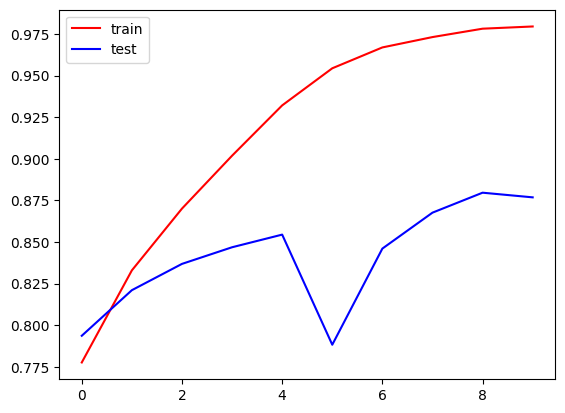

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],color='red',label='train')
plt.plot(history.history["val_accuracy"],color='blue',label='test')
plt.legend()
plt.show()


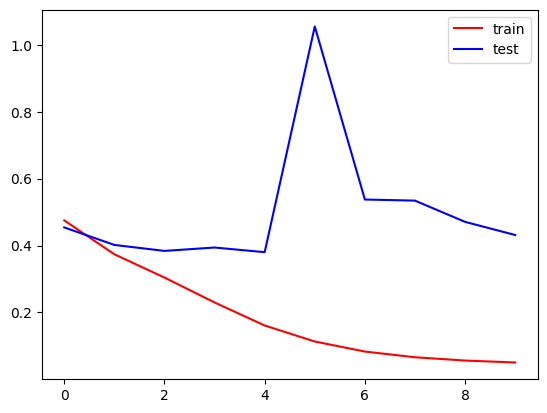

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"],color='red',label='train')
plt.plot(history.history["val_loss"],color='blue',label='test')
plt.legend()
plt.show()


In [57]:
import cv2

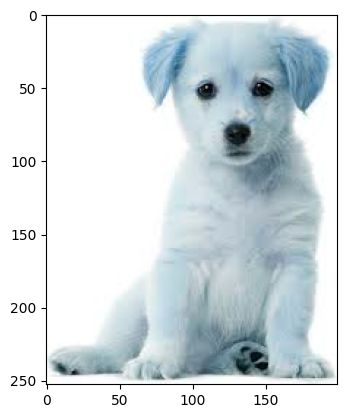

In [58]:
test_img=cv2.imread('/content/dog.jpeg')
plt.imshow(test_img)

In [59]:
test_img.shape

(253, 199, 3)

In [60]:
test_img=cv2.resize(test_img,(256,256))

In [61]:
test_input=test_img.reshape((1,256,256,3))

In [62]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.]], dtype=float32)

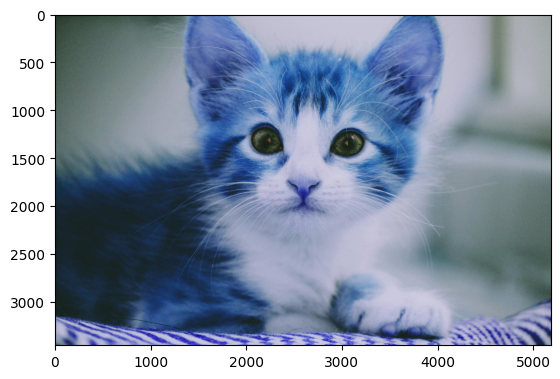

In [64]:
test_img2=cv2.imread('/content/catto.jpg')
plt.imshow(test_img2)

In [66]:
test_img2.shape

(3456, 5184, 3)

In [67]:
test_img2=cv2.resize(test_img2,(256,256))

In [68]:
test_input2=test_img2.reshape((1,256,256,3))

In [69]:
model.predict(test_input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


array([[0.]], dtype=float32)

In [ ]:
# here 0 means cat and 1 means dog